# Use case: Sentinel-1 ARD on a small area 

Earth Data Hub offers an innovative and super-efficient way to access data.

Here we present how to best access the service in one of the simplest use cases.

## Setup the environment

**If you haven't done it already, follow the [Getting started notebook](./00-getting-started.ipynb) to setup your environment and DestinE credentials.**

## Download 1 year of Sentinel-1 radiometrically corrected images on a small area

Our use case is to compute various statistice of Sentinel-1 radiometrically corrected images over a period of time, e.g. over 1 year or 31 accquisition dates. Note that we will be using the Sentinel-1 ARD datasets over Rome, Italy, acquired with relative orbit 117 and projected in the 33 north UTM zone.

The best practice for downloading data form the Earth Data Hub comprise the following steps:
1. open the dataset using the code snippet found on the page [Sentinel-1 ARD for relative orbit 117 on UTM 33N](https://earthdatahub.destine.eu/collections/sentinel-1-ard/datasets/IW-UTM-RO-italy-33N-117)
2. select the variable
3. select the area of interest (optionally alligning it on chunk boundaries)
4. select the time interval of interest
5. download the data to memory (with `.persist()` or `.compute()`)
6. save the data or compute the result in memory

### Open the dataset

The following assumes you set up the EDH Personal Access Token in your _netrc_ file.

In [1]:
import xarray as xr

s1_33n_117 = xr.open_dataset(
    "https://data.earthdatahub.destine.eu/sentinel-1-ard/IW-UTM-RO-italy-v0/Z33N/O117",
    storage_options={"client_kwargs": {"trust_env": True}},
    chunks={},
    engine="zarr",
    decode_coords="all",
)
s1_33n_117

<xarray.Dataset> Size: 1TB
Dimensions:       (date: 31, polarization: 2, y: 130000, x: 35000)
Coordinates:
  * date          (date) datetime64[ns] 248B 2024-01-06 ... 2024-12-31
  * polarization  (polarization) <U2 16B 'VV' 'VH'
  * y             (y) int64 1MB 4000005 4000015 4000025 ... 5299985 5299995
  * x             (x) int64 280kB 200005 200015 200025 ... 549975 549985 549995
    spatial_ref   int64 8B ...
Data variables:
    nrb           (date, polarization, y, x) float32 1TB dask.array<chunksize=(1, 1, 5000, 5000), meta=np.ndarray>
    simulation    (y, x) float32 18GB dask.array<chunksize=(5000, 5000), meta=np.ndarray>

### Select and prepare the variable

Note that all operation are lazy, that is are not applied to the whole 500GB of data, but are just recorded for later use. Download and computations are only done when requested.

In [2]:
nrb_vv_full = s1_33n_117.nrb.sel(polarization="VV")
nrb_vv_full

<xarray.DataArray 'nrb' (date: 31, y: 130000, x: 35000)> Size: 564GB
dask.array<getitem, shape=(31, 130000, 35000), dtype=float32, chunksize=(1, 5000, 5000), chunktype=numpy.ndarray>
Coordinates:
  * date          (date) datetime64[ns] 248B 2024-01-06 ... 2024-12-31
  * y             (y) int64 1MB 4000005 4000015 4000025 ... 5299985 5299995
  * x             (x) int64 280kB 200005 200015 200025 ... 549975 549985 549995
    polarization  <U2 8B 'VV'
    spatial_ref   int64 8B ...
Attributes:
    long_name:  normalised radar backscatter
    units:      m2 m-2

### Select the area of interest

For example we are interested in the area of Rome.

This a very convenient example as:
* it is a large enough area to be more interesting than a time-series of a single point,
* it is small enough to fit a single Zarr chunk, so the notebook can be run even with a slow internet connection,
* when plotted it is easy to identify even without adding coastlines and country borders that will make the notebook more complex.

In [3]:
aoi_selection = {
    "x": slice(267_000, 297_000),
    "y": slice(4_620_000, 4_650_000),
}
nrb_vv_aoi = nrb_vv_full.sel(aoi_selection)
nrb_vv_aoi

<xarray.DataArray 'nrb' (date: 31, y: 3000, x: 3000)> Size: 1GB
dask.array<getitem, shape=(31, 3000, 3000), dtype=float32, chunksize=(1, 3000, 3000), chunktype=numpy.ndarray>
Coordinates:
  * date          (date) datetime64[ns] 248B 2024-01-06 ... 2024-12-31
  * y             (y) int64 24kB 4620005 4620015 4620025 ... 4649985 4649995
  * x             (x) int64 24kB 267005 267015 267025 ... 296975 296985 296995
    polarization  <U2 8B 'VV'
    spatial_ref   int64 8B ...
Attributes:
    long_name:  normalised radar backscatter
    units:      m2 m-2

Note that the data size is now much smaller, we went from 500GB for global data to 1.5GB of our small area of interest.

We plot the image at one time to double check that the selection is correct:

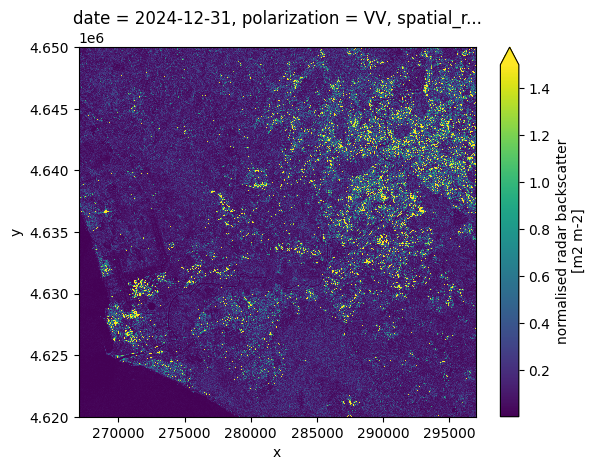

In [4]:
nrb_vv_aoi.isel(date=-1).plot(vmax=1.5)

### Optional: allign the area of interest on chunk boundaries

This a pro move and you can skip it.

When accessing the data in Zarr you always dowload whole chunks, even if you are only interestind in part of them. In the case of Sentinel-1 ARD datasets the spatial chunks are `(5000, 5000)` in size and even if you can read above that your DataArray in only 1.5GB of data you are most probably donwloading more data and then throwing a part of it away.

You can use the following (not very nice) code to grow your area of interest to the boundaries of the Zarr chunks, so you use all the data you donwload. Note that now you also have the size of the data that would be downloaded is it was not compressed (the data is in fact compressed so actual downlaod is smaller).

In [5]:
def align_indexer(step, indexer):
    if not isinstance(indexer, slice):
        return indexer
    assert indexer.step is None
    start = indexer.start // step * step if indexer.start else indexer.start
    stop = ((indexer.stop - 1) // step + 1) * step if indexer.stop else indexer.stop
    return slice(start, stop)


query_results = xr.core.indexing.map_index_queries(
    nrb_vv_full, indexers=aoi_selection, method=None, tolerance=None
)
print(query_results.dim_indexers)

aoi_iselection = {
    dim: align_indexer(5000, query_results.dim_indexers[dim])
    for dim in query_results.dim_indexers
}
print(aoi_iselection)

nrb_vv_aoi = nrb_vv_full.isel(aoi_iselection)
nrb_vv_aoi

{'x': slice(np.int64(6700), np.int64(9700), None), 'y': slice(np.int64(62000), np.int64(65000), None)}
{'x': slice(np.int64(5000), np.int64(10000), None), 'y': slice(np.int64(60000), np.int64(65000), None)}


<xarray.DataArray 'nrb' (date: 31, y: 5000, x: 5000)> Size: 3GB
dask.array<getitem, shape=(31, 5000, 5000), dtype=float32, chunksize=(1, 5000, 5000), chunktype=numpy.ndarray>
Coordinates:
  * date          (date) datetime64[ns] 248B 2024-01-06 ... 2024-12-31
  * y             (y) int64 40kB 4600005 4600015 4600025 ... 4649985 4649995
  * x             (x) int64 40kB 250005 250015 250025 ... 299975 299985 299995
    polarization  <U2 8B 'VV'
    spatial_ref   int64 8B ...
Attributes:
    long_name:  normalised radar backscatter
    units:      m2 m-2

So, the full time-series for a whole chunk is really 2.9GB, not 1.5GB.

Let's have a look at the area of the whole chunk.

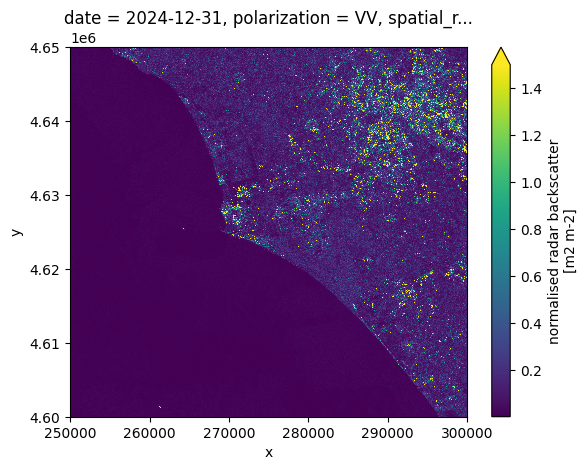

In [6]:
nrb_vv_aoi.isel(date=-1).plot(vmax=1.5)

### Select the time interval of interest

Since this dataset is only one year we get all the date available, but you can select on time if you are interested in a smaller time interval. And finally we have a definition of the data we want to download.

In [7]:
nrb_vv_aoi_toi = nrb_vv_aoi.sel(date="2024")
nrb_vv_aoi_toi

<xarray.DataArray 'nrb' (date: 31, y: 5000, x: 5000)> Size: 3GB
dask.array<getitem, shape=(31, 5000, 5000), dtype=float32, chunksize=(1, 5000, 5000), chunktype=numpy.ndarray>
Coordinates:
  * date          (date) datetime64[ns] 248B 2024-01-06 ... 2024-12-31
  * y             (y) int64 40kB 4600005 4600015 4600025 ... 4649985 4649995
  * x             (x) int64 40kB 250005 250015 250025 ... 299975 299985 299995
    polarization  <U2 8B 'VV'
    spatial_ref   int64 8B ...
Attributes:
    long_name:  normalised radar backscatter
    units:      m2 m-2

From the representation above we learn a few things:
1. the uncompressed data to be downloaded, e.g. 2.9GB (compression depends on the dataset and the variable)
2. the number of chunks to be downloaded, e.g. 31

### Download the data to memory

Finally we are ready to download only the data that we are interested in, in memory.

The best practice is to call the `.compute()` method load the data into a numpy array in memory.

**This operation is the slow one. It takes up to 40 minutes on a 8 Mbps connection.**

It depends on the download speed of your internet connection and on the load on the Earth Data Hub. The closer you are to the data the faster it is, and this is one of the reason the EDH is best suited to be used from within the DestinE platform.

In [8]:
%%time

nrb_vv_aoi_toi_data = nrb_vv_aoi_toi.compute()

CPU times: user 21 s, sys: 8.19 s, total: 29.1 s
Wall time: 5min 26s


### Perform any computation

Now that the data is in memory we can perform arbitrary computations.

#### High change areas south of Rome

Typical use cases for Sentine-1 data is to detect changes on the gound. A very simple way to identify areas with changes is to compute the relative standard deviation of the radar intensity. Areas wth high change are typically associated to movements of large metal objects, like vehicles, containers, contruction mterials, etc.

We start by reducing the selection to include molty land.

In [9]:
nrb_rome = nrb_vv_aoi_toi_data.sel(**aoi_selection)

#### Plot one image and the average over a year

First we plot the last image of 2024. Zooming you meay notice the typical gainy texture of SAR images.

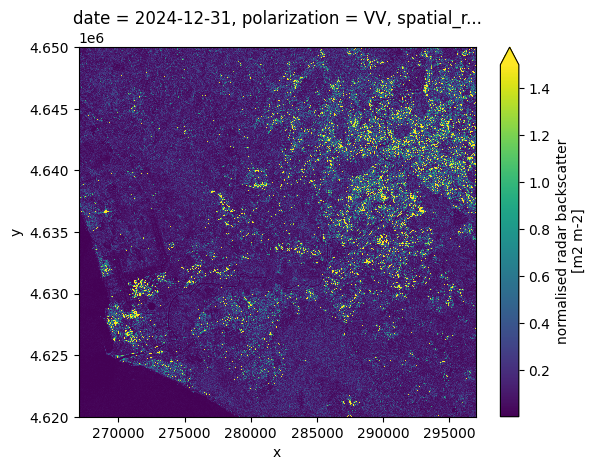

In [10]:
nrb_rome.isel(date=-1).plot(vmax=1.5)

Then we plot the average over the 31 images of 2024. Zooming you may notice fetures are much sharper and the texture is much smoother.

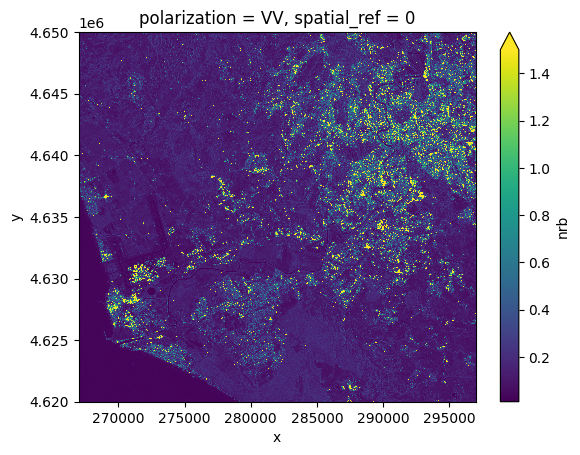

In [11]:
nrb_rome.mean("date").plot(vmax=1.5)

#### Identify area that change a lot

We compute the realative standard deviation of each pixel of the 31 images in one line, than we plot the result.

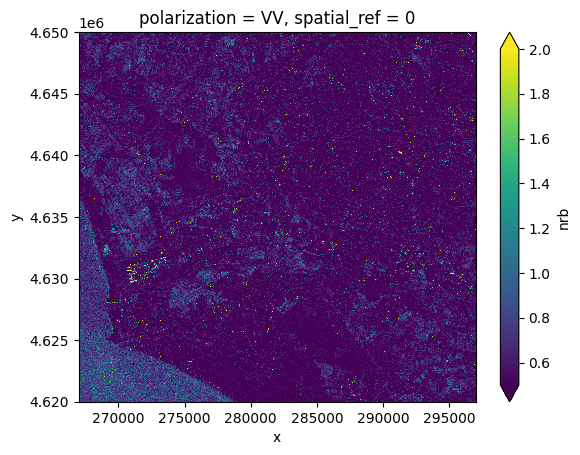

In [12]:
relative_std_rome = nrb_rome.std("date") / nrb_rome.mean("date")
relative_std_rome.plot(vmin=0.5, vmax=2)

The resulting image has several bright points (typically localized changes in the amount of metal structures in the pixels) and a few extended areas (typically arable land with high seasonl changes).

The peculiar feature that stands out is the bright region close to the sea because it too bright to be agricultural land and quite extend to be a construction site.

Let's zoom in.

#### Simple analisys of a local change

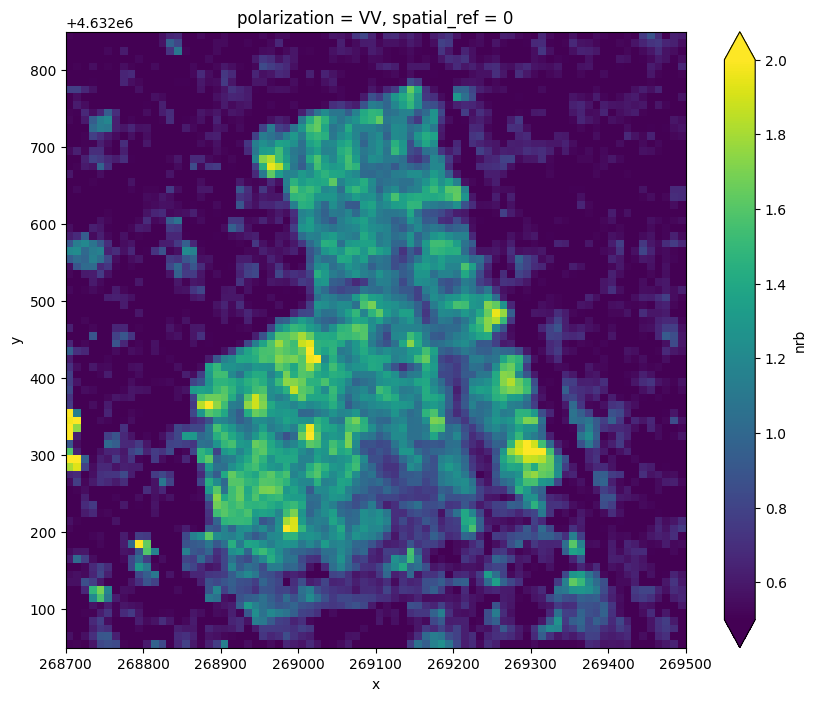

In [13]:
x_0, y_0 = 269_100, 4_632_450
width = 400
aoi = dict(x=slice(x_0 - width, x_0 + width + 1), y=slice(y_0 - width, y_0 + width + 1))

nrb_area = nrb_rome.sel(**aoi)
relative_std_area = relative_std_rome.sel(**aoi)

relative_std_area.sel(**aoi).plot(vmin=0.5, vmax=2, figsize=(10, 8))

The area has sharp edges and a relavie standad deviation up to 200% of the mean value in the year.

We first compute the difference between the mean and every image and we plot the average difference as a funciton of time, to see when the changes happened.

In [14]:
nrb_area_anomaly = nrb_area - nrb_area.mean("date")
nrb_area_anomaly

<xarray.DataArray 'nrb' (date: 31, y: 80, x: 80)> Size: 794kB
array([[[-4.27187026e-01,  1.62603557e-01,  1.36225551e-01, ...,
          9.56159979e-02,  9.43027586e-02,  6.60882741e-02],
        [-4.38445032e-01, -1.22424662e-02,  7.58219063e-02, ...,
         -6.20215610e-02, -5.89766949e-02,  2.62780935e-02],
        [-1.80321455e-01, -5.13325334e-02, -9.96723771e-02, ...,
         -6.35356307e-02, -7.22498745e-02, -2.99392194e-02],
        ...,
        [ 2.79566616e-01,  3.30964148e-01,  2.24711776e-01, ...,
          1.40828788e-02,  1.03014052e-01,  3.19223702e-02],
        [ 1.44369811e-01,  4.98362184e-02,  2.60443091e-02, ...,
         -2.29521841e-03,  2.73937099e-02,  8.73098075e-02],
        [-1.23111844e-01, -2.09858537e-01, -3.74527454e-01, ...,
         -6.56349584e-03, -1.78498290e-02,  5.59959412e-02]],

       [[-2.55189955e-01, -2.01593220e-01, -5.73779643e-02, ...,
          8.67048651e-02,  4.30332273e-02, -3.61913890e-02],
        [-2.91838586e-01, -2.16893345e-01, -3.59944999e-02, ...,
          6.97533414e-02,  5.25040179e-02, -3.07981670e-03],
        [-2.44286299e-01, -4.15669084e-02,  2.36186385e-02, ...,
          9.75971818e-02,  1.19786412e-02,  5.06882221e-02],
...
          3.66048515e-02,  5.60194626e-03, -5.30907512e-03],
        [-1.36147767e-01, -1.65495813e-01,  1.04657590e-01, ...,
         -9.64995474e-03, -1.71314366e-02, -6.59278035e-03],
        [-1.89640164e-01, -1.56635880e-01,  3.70589733e-01, ...,
         -2.26157419e-02, -4.00055908e-02, -3.65943909e-02]],

       [[ 3.06821764e-01,  5.17637134e-02,  3.93017232e-02, ...,
         -9.04496759e-02, -6.09706789e-02,  2.24481374e-02],
        [ 6.39802039e-01,  1.33753628e-01, -1.63252801e-01, ...,
         -6.83386996e-02, -2.43392438e-02,  5.77722341e-02],
        [-1.20995283e-01, -2.09535658e-01, -1.86176896e-02, ...,
         -3.17973495e-02, -1.29237026e-02,  3.39645892e-02],
        ...,
        [ 2.07789272e-01,  4.33664918e-02, -1.25874162e-01, ...,
         -6.24182820e-03, -1.53331123e-02,  9.58350301e-03],
        [-3.82473767e-02, -1.13005579e-01, -1.29961550e-01, ...,
         -2.37795934e-02, -1.38050206e-02, -4.67017293e-03],
        [ 3.36264372e-02,  1.62700057e-01,  2.68397331e-02, ...,
         -2.54538767e-02, -2.48993896e-02, -2.86903381e-02]]],
      shape=(31, 80, 80), dtype=float32)
Coordinates:
  * date          (date) datetime64[ns] 248B 2024-01-06 ... 2024-12-31
  * y             (y) int64 640B 4632055 4632065 4632075 ... 4632835 4632845
  * x             (x) int64 640B 268705 268715 268725 ... 269475 269485 269495
    polarization  <U2 8B 'VV'
    spatial_ref   int64 8B 0

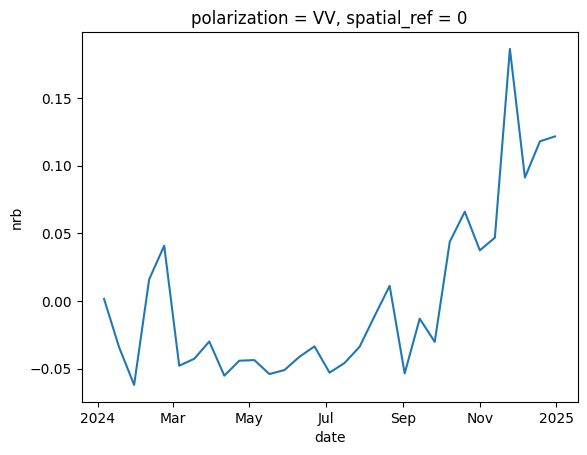

In [15]:
nrb_area_anomaly.mean(["x", "y"]).plot()

Looks like the area changed from low reflectance to high reflectance quite suddently between october and november.

Again with one line we can compute and plot the monthly means:

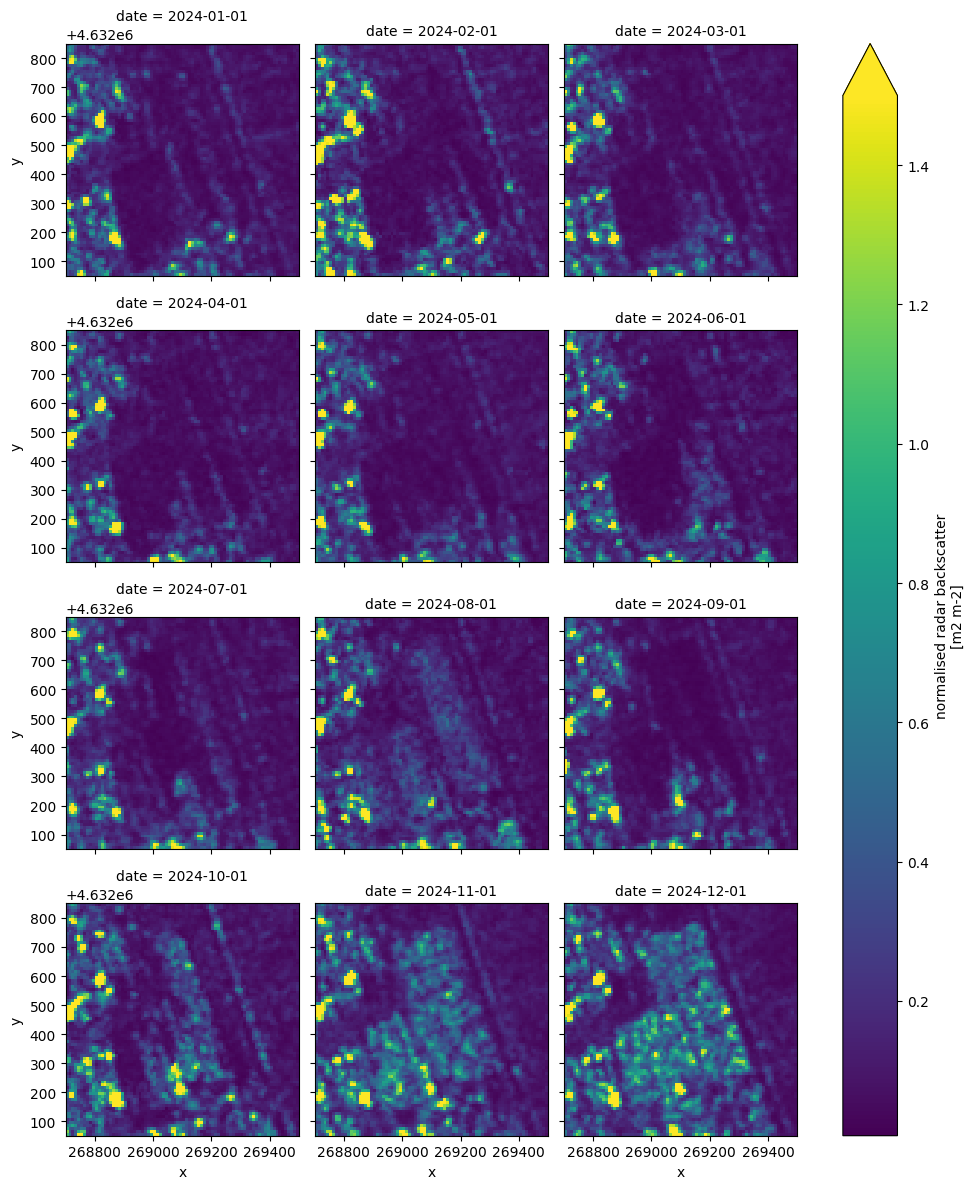

In [16]:
nrb_area.resample(date="MS").mean().plot(col="date", col_wrap=3, vmax=1.5)

The monthly mean images clearly show that the whole area fills with high reflectivity "objects" very quickly and quite homogeneously, that is a highly unusual occurrence.

Looking at the area in historic optical images the area appears to be a long term parking area that was almost unused until recently when it suddently become almost completly filled with cars.

This is a typical combination with SAR images used to detech changes and optical images used to recognise the kind of change.